In [5466]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel
from keras.models import Sequential
from keras.layers import Dense
import keras.losses
import tensorflow as tf

import sys
sys.path.append('../src')

from yf_dataset import *
from ta_features import *
from preprocessing import *

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.decomposition import PCA
from keras.optimizers import Adam
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature
from sklearn.metrics import r2_score, explained_variance_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer, mean_absolute_percentage_error, mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from tensorflow.keras.losses import MeanAbsoluteError, Huber
from tensorflow.keras import backend as K
from keras.layers import Dropout


In [5467]:
ticker = 'amd'
label = 'AMD'
start_date = '2017-01-01'
close_price_period = '1d'
target_pct_change_period = 30 # n = period

In [5468]:
amd_df = get_stock_data(ticker, start_date, period=close_price_period)
format_col_names(amd_df)

[*********************100%%**********************]  1 of 1 completed


In [5469]:
# Check for missing values in each column
missing_values = amd_df.isnull().sum()

# Display the result
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
Open         0
High         0
Low          0
Close        0
Adj_Close    0
Volume       0
dtype: int64


In [5470]:
amd_df.head()

,Open,High,Low,Close,Adj_Close,Volume
Date,,,,,,
2017-01-03,11.42,11.65,11.02,11.43,11.43,55182000
2017-01-04,11.45,11.52,11.24,11.43,11.43,40781200
2017-01-05,11.43,11.69,11.23,11.24,11.24,38855200
2017-01-06,11.29,11.49,11.11,11.32,11.32,34453500
2017-01-09,11.37,11.64,11.31,11.49,11.49,37304800


In [5471]:
add_pct_ch_and_future(amd_df, period = target_pct_change_period)

c:\Users\user\Desktop\FMLProject\FML\notebooks\../src\ta_features.py:14: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  df[str(period) + 'd_close_future_pct'] = df[str(period) + 'd_future_close'].pct_change(period) #calc future % change


Index(['Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume', '30d_close_pct',
       '30d_future_close', '30d_close_future_pct'],
      dtype='object')

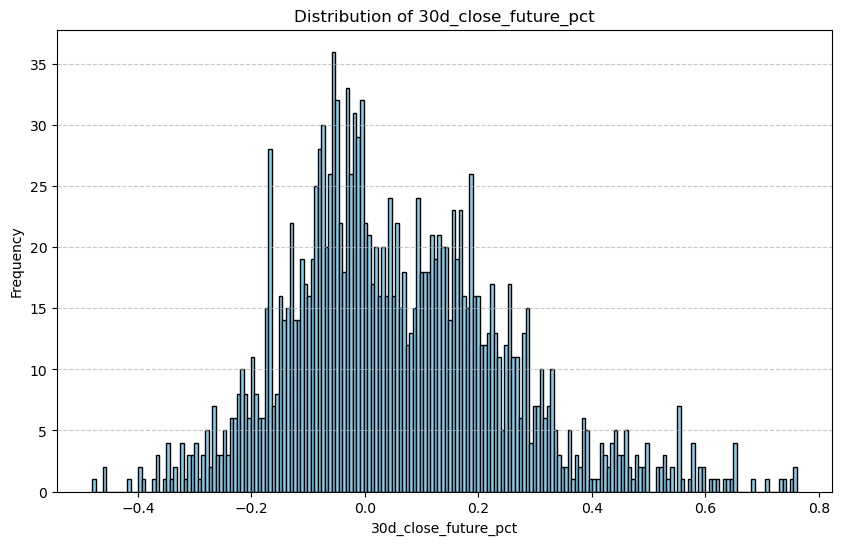

In [5472]:
# Replace 'target_pct_change_periodd_close_future_pct' with your actual column name
target_column = f'{target_pct_change_period}d_close_future_pct'

# Plot the distribution using a histogram
plt.figure(figsize=(10, 6))
plt.hist(amd_df[target_column], bins=200, color='skyblue', edgecolor='black')
plt.title(f'Distribution of {target_column}')
plt.xlabel(target_column)
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [5473]:
add_sma_rsi_sma_x_rsi(amd_df, [7, 14, 20, 50, 100])
add_ema(amd_df, [7, 14, 20, 50, 100])
add_wma(amd_df, [7, 14, 20, 50, 100])

add_volume_1d_pct_change_sma(amd_df, 5)
add_volume_1d_pct_change_sma(amd_df, 10)
add_volume_1d_pct_change_sma(amd_df, 30)
add_volume_1d_pct_change_sma(amd_df, 60)
add_volume_1d_pct_change_sma(amd_df, 90)

amd_df = add_datetime_features(amd_df,["month", "quarter"])

amd_df = add_macd_feature(amd_df)


amd_df['Log_Volume'] = amd_df['Volume'].apply(np.log)

In [5474]:
add_n_day_std(amd_df, 7)
add_n_day_std(amd_df, 14)

add_lower_confidence_interval(amd_df, 7)
add_lower_confidence_interval(amd_df, 14)

add_upper_confidence_interval(amd_df, 7)
add_upper_confidence_interval(amd_df, 14)


Index(['Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume', '30d_close_pct',
       '30d_future_close', '30d_close_future_pct', 'sma7', 'rsi7', 'SMAxRSI_7',
       'sma14', 'rsi14', 'SMAxRSI_14', 'sma20', 'rsi20', 'SMAxRSI_20', 'sma50',
       'rsi50', 'SMAxRSI_50', 'sma100', 'rsi100', 'SMAxRSI_100', 'ema7',
       'ema14', 'ema20', 'ema50', 'ema100', 'wma7', 'wma14', 'wma20', 'wma50',
       'wma100', 'Volume_1d_change', 'Volume_5d_change_SMA',
       'Volume_10d_change_SMA', 'Volume_30d_change_SMA',
       'Volume_60d_change_SMA', 'Volume_90d_change_SMA', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'quarter_1', 'quarter_2',
       'quarter_3', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9',
       'Log_Volume', '7d_std', '14d_std', '7d_upper_conf_interval',
       '14d_upper_conf_interval'],
      dtype='object')

In [5475]:
add_downward_pressure(amd_df)
add_upward_pressure(amd_df)

add_cumulative_return(amd_df)

amd_df = add_stochastic_oscillator(amd_df)

In [5476]:
add_atr(amd_df, 14)
amd_df = add_adx(amd_df, 7)
amd_df = add_adx(amd_df, 14)

In [5477]:
amd_df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume', '30d_close_pct',
       '30d_future_close', '30d_close_future_pct', 'sma7', 'rsi7', 'SMAxRSI_7',
       'sma14', 'rsi14', 'SMAxRSI_14', 'sma20', 'rsi20', 'SMAxRSI_20', 'sma50',
       'rsi50', 'SMAxRSI_50', 'sma100', 'rsi100', 'SMAxRSI_100', 'ema7',
       'ema14', 'ema20', 'ema50', 'ema100', 'wma7', 'wma14', 'wma20', 'wma50',
       'wma100', 'Volume_1d_change', 'Volume_5d_change_SMA',
       'Volume_10d_change_SMA', 'Volume_30d_change_SMA',
       'Volume_60d_change_SMA', 'Volume_90d_change_SMA', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'quarter_1', 'quarter_2',
       'quarter_3', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9',
       'Log_Volume', '7d_std', '14d_std', '7d_upper_conf_interval',
       '14d_upper_conf_interval', 'Downward_Pressure', 'Upward_Pressure',
       'Cumulative_Return', 'STOCHk_14_3_3', 'STOCHd_14_3_3

In [5478]:
amd_df.dropna(inplace=True)
amd_df.head()

,Open,High,Low,Close,Adj_Close,Volume,30d_close_pct,30d_future_close,30d_close_future_pct,sma7,...,Cumulative_Return,STOCHk_14_3_3,STOCHd_14_3_3,ATR,ADX_7,DMP_7,DMN_7,ADX_14,DMP_14,DMN_14
Date,,,,,,,,,,,,,,,,,,,,,
2017-05-26,10.85,11.02,10.74,11.00,11.00,31907600,-0.106418,13.89,0.262727,11.070000,...,-0.037620,34.704263,34.946769,0.588041,21.305427,18.127137,26.880145,20.022117,20.269008,28.803137
2017-05-30,10.95,11.27,10.90,11.12,11.12,35339000,-0.130571,14.29,0.285072,11.047143,...,-0.027122,33.141058,34.005872,0.572458,18.528247,23.225412,24.108268,19.308941,22.453856,27.472638
2017-05-31,11.29,11.49,11.10,11.19,11.19,42929000,-0.135907,13.53,0.209115,11.015714,...,-0.020997,31.377533,33.074285,0.559419,17.525381,26.959965,21.395166,18.206584,24.145645,26.103883
2017-06-01,11.25,11.29,10.81,10.93,10.93,48002000,-0.148754,13.92,0.273559,11.000000,...,-0.043745,24.462130,29.660240,0.553743,16.053680,23.209467,26.823594,17.688755,22.649913,28.229433
2017-06-02,10.93,10.96,10.57,10.90,10.90,43056200,-0.168574,13.80,0.266055,11.001428,...,-0.046369,19.835692,25.225118,0.542042,16.641887,20.505448,30.868066,17.599739,21.485342,29.942061


In [5479]:
# Check for duplicate column names
duplicates = amd_df.columns[amd_df.columns.duplicated()]
print("Duplicate Columns:", duplicates)

Duplicate Columns: Index([], dtype='object')


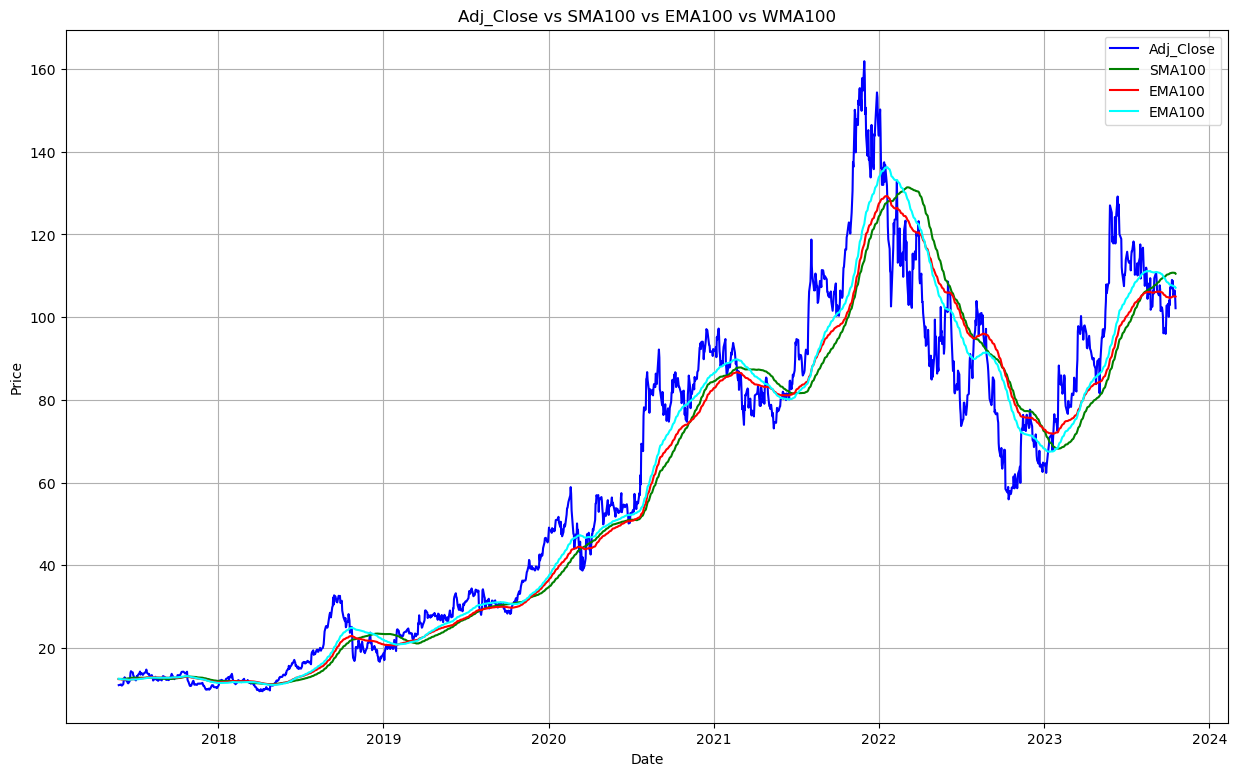

In [5480]:
# Plotting
plt.figure(figsize=(15, 9))

# Plot Adj_Close
plt.plot(amd_df['Adj_Close'], label='Adj_Close', color='blue')

# Plot SMA200
plt.plot(amd_df['sma100'], label='SMA100', color='green')

# Plot EMA200
plt.plot(amd_df['ema100'], label='EMA100', color='red')

# Plot EMA200
plt.plot(amd_df['wma100'], label='EMA100', color='cyan')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Adj_Close vs SMA100 vs EMA100 vs WMA100')
plt.legend()
plt.grid(True)
plt.show()

In [5481]:
features, target = split_features_target(amd_df, f'{target_pct_change_period}d_close_future_pct', [f'{target_pct_change_period}d_future_close'])

In [5482]:
X = amd_df[features]
y = amd_df[target]

# Identify columns to exclude from scaling
exclude_prefixes = ['weekday_','month_', 'quarter_']
categorical_features = [col for col in features if any(col.startswith(prefix) for prefix in exclude_prefixes)]
# Transform to 1s and 0s
X[categorical_features] = X[categorical_features].astype(int)

X.shape,y.shape
len(features)

C:\Users\user\AppData\Local\Temp\ipykernel_27576\1123186071.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[categorical_features] = X[categorical_features].astype(int)


72

In [5483]:
scaler = MinMaxScaler()
method = 'yeo-johnson'
transformer = PowerTransformer(method=method)
# Identify columns to scale
features_to_scale = [col for col in features if col not in categorical_features]

# Subset your data with only the features to scale
X_subset = X[features_to_scale]  # Replace X with your actual data

# Apply MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_subset)

# Apply PowerTransformer
method = 'yeo-johnson'
transformer = PowerTransformer(method=method)
X_transformed = transformer.fit_transform(X_scaled)

# Replace the scaled and transformed features back into the original DataFrame
X[features_to_scale] = X_transformed

c:\Users\user\anaconda3\envs\financial_ml_env\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\user\anaconda3\envs\financial_ml_env\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\user\anaconda3\envs\financial_ml_env\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\user\anaconda3\envs\financial_ml_env\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be

In [5484]:
# Create a time series split
n_splits = 6
n_samples = X.shape[0]                             # this is how test_size (s)
s = n_samples//(n_splits + 1)                      # is evaluated internally              

X_train, X_test = X[ :-s], X[-s: ]    # s=2 for this split
y_train, y_test = y[ :-s], y[-s: ]

y_train.shape, y_test.shape

((1380,), (230,))

In [5485]:
# Mutual Information Feature Selection
mi_selector = SelectKBest(mutual_info_regression, k=40)
X_train_mi = mi_selector.fit_transform(X_train, y_train)
selected_features_mi = X.columns[mi_selector.get_support()]

# P-value Feature Selection
f_selector = SelectKBest(f_regression, k=40)
X_train_f = f_selector.fit_transform(X_train, y_train)
selected_features_f = X.columns[f_selector.get_support()]

# Obtain the list of features present in both selected_features_mi and selected_features_f
common_features = set(selected_features_mi) & set(selected_features_f)

# Print the common features
print("Common Features:", common_features)

# Convert the set to a list before using it as a column indexer
common_features_list = list(common_features)
len(common_features)

c:\Users\user\anaconda3\envs\financial_ml_env\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\user\anaconda3\envs\financial_ml_env\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\user\anaconda3\envs\financial_ml_env\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\user\anaconda3\envs\financial_ml_env\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be

Common Features: {'sma100', 'SMAxRSI_14', 'Close', 'Cumulative_Return', '7d_upper_conf_interval', 'SMAxRSI_7', 'High', 'Adj_Close', 'Open', 'wma100', 'wma50', '14d_upper_conf_interval', 'ema20', 'SMAxRSI_20', '7d_std', '14d_std', 'sma14', 'sma20', 'ATR', 'SMAxRSI_100', 'wma20', '30d_close_pct', 'ema100', 'sma7', 'ema50', 'SMAxRSI_50', 'sma50', 'ADX_14', 'wma7', 'ema14', 'ema7', 'Low', 'wma14'}


c:\Users\user\anaconda3\envs\financial_ml_env\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\user\anaconda3\envs\financial_ml_env\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\user\anaconda3\envs\financial_ml_env\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\user\anaconda3\envs\financial_ml_env\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be

33

In [5486]:
X_train = X_train[common_features_list]
X_test = X_test[common_features_list]

In [5487]:
# Identify columns to exclude from scaling
exclude_prefixes = ['weekday_', 'month_', 'quarter_']
categorical_features = [col for col in common_features if any(col.startswith(prefix) for prefix in exclude_prefixes)]

# Transform to 1s and 0s
X_train[categorical_features] = X_train[categorical_features].astype(int)
X_test[categorical_features] = X_test[categorical_features].astype(int)

In [5488]:
X_train.head()

,sma100,SMAxRSI_14,Close,Cumulative_Return,7d_upper_conf_interval,SMAxRSI_7,High,Adj_Close,Open,wma100,...,sma7,ema50,SMAxRSI_50,sma50,ADX_14,wma7,ema14,ema7,Low,wma14
Date,,,,,,,,,,,,,,,,,,,,,
2017-05-26,-1.310971,-1.484522,-1.406971,-1.406971,-1.417662,-1.454933,-1.416156,-1.406971,-1.412437,-1.324073,...,-1.402131,-1.350996,-1.402901,-1.329722,-0.137367,-1.405410,-1.394234,-1.402305,-1.406736,-1.397386
2017-05-30,-1.311087,-1.469616,-1.402711,-1.402711,-1.419782,-1.422753,-1.407405,-1.402711,-1.408877,-1.325062,...,-1.402947,-1.352216,-1.400638,-1.331434,-0.238158,-1.404965,-1.394653,-1.401808,-1.400945,-1.397549
2017-05-31,-1.311106,-1.461012,-1.400228,-1.400228,-1.425425,-1.404093,-1.399718,-1.400228,-1.396795,-1.325997,...,-1.404068,-1.353291,-1.400534,-1.333753,-0.402670,-1.403693,-1.394684,-1.400813,-1.393715,-1.397698
2017-06-01,-1.311252,-1.485228,-1.409457,-1.409457,-1.425707,-1.476280,-1.406706,-1.409457,-1.398215,-1.327120,...,-1.404628,-1.354690,-1.409651,-1.335842,-0.483826,-1.404456,-1.395946,-1.402378,-1.404201,-1.399219
2017-06-02,-1.311473,-1.488858,-1.410523,-1.410523,-1.425763,-1.484285,-1.418259,-1.410523,-1.409589,-1.328262,...,-1.404577,-1.356077,-1.412579,-1.338156,-0.498038,-1.405346,-1.397182,-1.403820,-1.412897,-1.400836


In [5489]:
X_test.shape

(230, 33)

In [5490]:
X_train.head()

,sma100,SMAxRSI_14,Close,Cumulative_Return,7d_upper_conf_interval,SMAxRSI_7,High,Adj_Close,Open,wma100,...,sma7,ema50,SMAxRSI_50,sma50,ADX_14,wma7,ema14,ema7,Low,wma14
Date,,,,,,,,,,,,,,,,,,,,,
2017-05-26,-1.310971,-1.484522,-1.406971,-1.406971,-1.417662,-1.454933,-1.416156,-1.406971,-1.412437,-1.324073,...,-1.402131,-1.350996,-1.402901,-1.329722,-0.137367,-1.405410,-1.394234,-1.402305,-1.406736,-1.397386
2017-05-30,-1.311087,-1.469616,-1.402711,-1.402711,-1.419782,-1.422753,-1.407405,-1.402711,-1.408877,-1.325062,...,-1.402947,-1.352216,-1.400638,-1.331434,-0.238158,-1.404965,-1.394653,-1.401808,-1.400945,-1.397549
2017-05-31,-1.311106,-1.461012,-1.400228,-1.400228,-1.425425,-1.404093,-1.399718,-1.400228,-1.396795,-1.325997,...,-1.404068,-1.353291,-1.400534,-1.333753,-0.402670,-1.403693,-1.394684,-1.400813,-1.393715,-1.397698
2017-06-01,-1.311252,-1.485228,-1.409457,-1.409457,-1.425707,-1.476280,-1.406706,-1.409457,-1.398215,-1.327120,...,-1.404628,-1.354690,-1.409651,-1.335842,-0.483826,-1.404456,-1.395946,-1.402378,-1.404201,-1.399219
2017-06-02,-1.311473,-1.488858,-1.410523,-1.410523,-1.425763,-1.484285,-1.418259,-1.410523,-1.409589,-1.328262,...,-1.404577,-1.356077,-1.412579,-1.338156,-0.498038,-1.405346,-1.397182,-1.403820,-1.412897,-1.400836


In [5491]:
def sign_penalty_loss(y_true, y_pred):
    penalty_factor = 6
    diff = y_true - y_pred
    penalty = tf.where(tf.less(tf.sign(y_true * y_pred), 0), penalty_factor*tf.square(diff), tf.square(diff))
    return tf.reduce_mean(tf.square(diff) * (1 + penalty)/2)

In [5492]:
# Create the model
model_1 = Sequential()
model_1.add(Dense(100, input_dim=X_train.shape[1], activation='relu'))
model_1.add(Dropout(0.2))
model_1.add(Dense(50, activation='relu'))
model_1.add(Dropout(0.2))
model_1.add(Dense(20, activation='relu'))
model_1.add(Dense(10, activation='relu'))
model_1.add(Dense(1, activation='linear'))

# Fit the model

# Fit the model with our custom 'sign_penalty' loss function
model_1.compile(optimizer=Adam(0.001), loss=sign_penalty_loss)

scaler = StandardScaler()
method = 'yeo-johnson'
transformer = PowerTransformer(method=method)
# Identify columns to scale
features_to_scale = [col for col in common_features if col not in categorical_features]

history = model_1.fit(X_train, y_train, epochs=300)

Epoch 1/300


44/44 [==============================] - 1s 1ms/step - loss: 0.0389
Epoch 2/300
44/44 [==============================] - 0s 1ms/step - loss: 0.0281
Epoch 3/300
44/44 [==============================] - 0s 1ms/step - loss: 0.0271
Epoch 4/300
44/44 [==============================] - 0s 1ms/step - loss: 0.0240
Epoch 5/300
44/44 [==============================] - 0s 1ms/step - loss: 0.0227
Epoch 6/300
44/44 [==============================] - 0s 1ms/step - loss: 0.0212
Epoch 7/300
44/44 [==============================] - 0s 1ms/step - loss: 0.0207
Epoch 8/300
44/44 [==============================] - 0s 1ms/step - loss: 0.0207
Epoch 9/300
44/44 [==============================] - 0s 1ms/step - loss: 0.0206
Epoch 10/300
44/44 [==============================] - 0s 1ms/step - loss: 0.0197
Epoch 11/300
44/44 [==============================] - 0s 1ms/step - loss: 0.0192
Epoch 12/300
44/44 [==============================] - 0s 1ms/step - loss: 0.0193
Epoch 13/300
44/44 [=============================

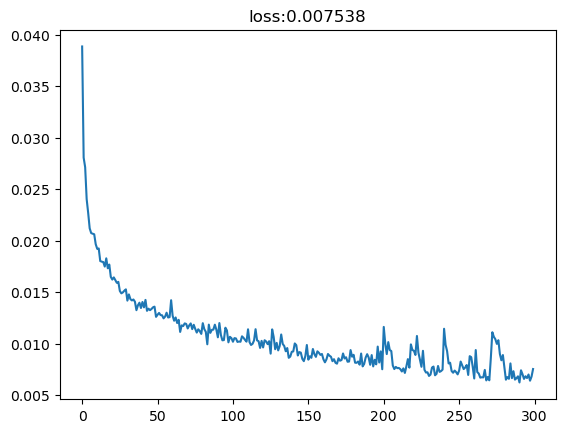

In [5493]:
plt.plot(history.history['loss'])
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show()

In [5494]:
def smape_score(y_true, y_pred):
    y_true = np.ravel(y_true)
    y_pred = np.ravel(y_pred)

    denominator = np.abs(y_true) + np.abs(y_pred)
    # Check if both y_true and y_pred are 0
    both_zero_mask = (y_true == 0) & (y_pred == 0)
    # If both are 0, set diff to 0 to avoid division by zero
    diff = np.where(both_zero_mask, 0, np.abs(y_true - y_pred) / denominator)
    return 100 * np.mean(diff)

y_pred = model_1.predict(X_test)
print(f'sMAPE score: {smape_score(y_test, y_pred)}')


8/8 [==============================] - 0s 930us/step
sMAPE score: 64.79589403889237


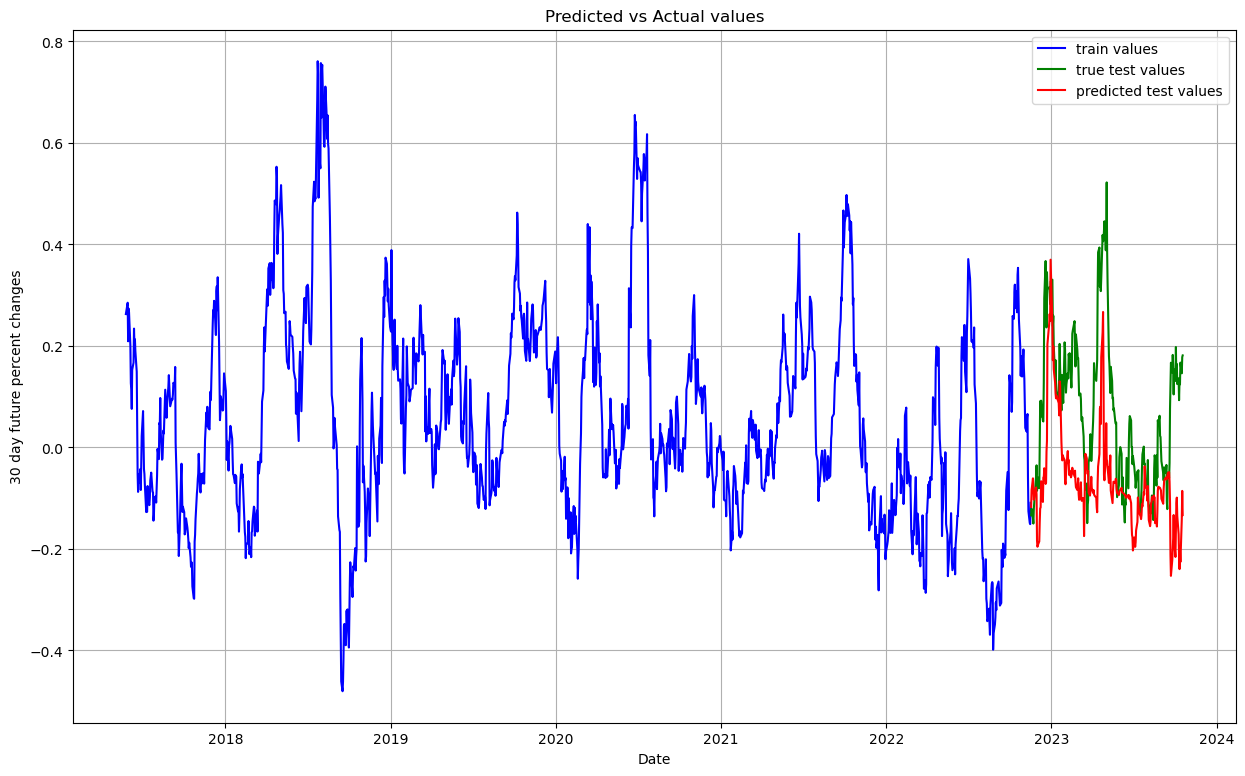

In [5495]:
y_pred = pd.DataFrame(y_pred)
y_pred = y_pred.set_index(y_test.index)

# Plotting
plt.figure(figsize=(15, 9))

plt.plot(y_train, label='train values', color='blue')
plt.plot(y_test, label='true test values', color='green')
plt.plot(y_pred, label='predicted test values', color='red')

# Add labels and title
plt.xlabel('Date')
plt.ylabel(f'{target_pct_change_period} day future percent changes')
plt.title('Predicted vs Actual values')
plt.legend()
plt.grid(True)
plt.show()

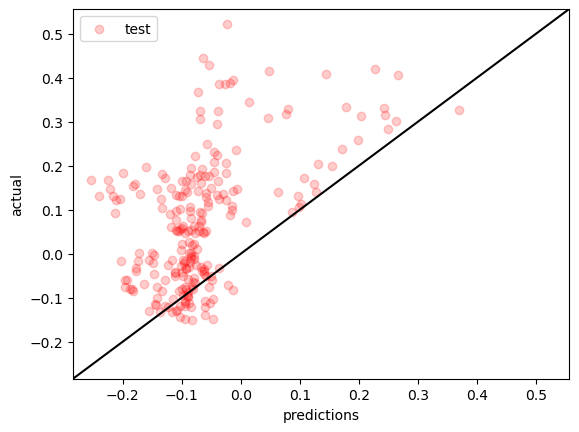

In [5496]:
# Scatter the predictions vs the targets with 20% opacity
# plt.scatter(pred_train, y_train, alpha=0.2, color='b', label='train')
plt.scatter(y_pred, y_test, alpha=0.2, color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
perfect_line = np.arange(min(xmin, ymin), max(xmax, ymax), 0.01)
plt.plot(perfect_line, perfect_line, c='k')

# Set the same limits on x and y axes
plt.xlim([min(xmin, ymin), max(xmax, ymax)])
plt.ylim([min(xmin, ymin), max(xmax, ymax)])

# Set the axis labels and show the plot
plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()  # show the legend
plt.show()